In [97]:
import re
import pandas as pd
import numpy as np
from plotnine import *
from mizani.formatters import percent_format
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from py_helper_functions import *
import warnings

warnings.filterwarnings("ignore")

## Data Prepare

In [2]:
data = pd.read_csv('listings.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            18288 non-null  int64  
 1   listing_url                                   18288 non-null  object 
 2   scrape_id                                     18288 non-null  int64  
 3   last_scraped                                  18288 non-null  object 
 4   name                                          18259 non-null  object 
 5   description                                   17744 non-null  object 
 6   neighborhood_overview                         9585 non-null   object 
 7   picture_url                                   18288 non-null  object 
 8   host_id                                       18288 non-null  int64  
 9   host_url                                      18288 non-null 

In [4]:
data.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20210921151214,2021-09-22,Berlin-Mitte Value! Quiet courtyard/very central,Great location! <br />30 of 75 sq meters. Thi...,It is located in the former East Berlin area o...,https://a0.muscache.com/pictures/260fd609-710a...,2217,https://www.airbnb.com/users/show/2217,...,4.89,4.96,4.59,NaN,f,5,5,0,0,2.15
1,3176,https://www.airbnb.com/rooms/3176,20210921151214,2021-09-22,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,The neighbourhood is famous for its variety of...,https://a0.muscache.com/pictures/243355/84afcf...,3718,https://www.airbnb.com/users/show/3718,...,4.69,4.92,4.63,NaN,f,1,1,0,0,1.12
2,7071,https://www.airbnb.com/rooms/7071,20210921151214,2021-09-22,BrightRoom with sunny greenview!,Cozy and large room in the beautiful district ...,"Great neighborhood with plenty of Cafés, Baker...",https://a0.muscache.com/pictures/21278/32a1622...,17391,https://www.airbnb.com/users/show/17391,...,4.85,4.91,4.71,NaN,t,1,0,1,0,2.40
3,9991,https://www.airbnb.com/rooms/9991,20210921151214,2021-09-22,Geourgeous flat - outstanding views,4 bedroom with very large windows and outstand...,Prenzlauer Berg is an amazing neighbourhood wh...,https://a0.muscache.com/pictures/42799131/59c8...,33852,https://www.airbnb.com/users/show/33852,...,5.00,4.86,4.86,03/Z/RA/003410-18,f,1,1,0,0,0.16
4,14325,https://www.airbnb.com/rooms/14325,20210921151214,2021-09-22,Apartment in Prenzlauer Berg,The apartment is located on the upper second f...,NaN,https://a0.muscache.com/pictures/508703/24988a...,55531,https://www.airbnb.com/users/show/55531,...,4.84,4.58,4.42,NaN,f,3,3,0,0,0.26


In [5]:
len(data)  # the total number of Berlin airbnb data

18288

In [6]:
# Size, we need a normal apartment, 2-6persons according to assignment
data=data.loc[(data.accommodates < 7) & (data.accommodates > 1)]

In [7]:
len(data)  # after selecting

15611

In [8]:
# show the columns of missing value
na_filter=data.isna().sum()
na_filter[na_filter > 0].index

Index(['name', 'description', 'neighborhood_overview', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'calendar_updated',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'license',
       'reviews_per_month'],
      dtype='object')

In [9]:
# process the missing value
# fill median strategy with these attributes:
data['host_listings_count']=data['host_listings_count'].fillna(np.nanmedian(data['host_listings_count']))
data['host_total_listings_count']=data['host_total_listings_count'].fillna(np.nanmedian(data['host_total_listings_count']))
data['bedrooms']=data['bedrooms'].fillna(np.nanmedian(data['bedrooms']))
data['beds']=data['beds'].fillna(np.nanmedian(data['beds']))

# drop these attributes: Because there are too many missing
data.drop(columns=['bathrooms', 'calendar_updated', 'license', 'neighbourhood',
                  'neighborhood_overview', 'host_about', 'host_response_time',
                  'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood'], inplace=True)

# drop rows if no value on these attributes
data.dropna(subset=['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                    'review_scores_value', 'reviews_per_month', 'bathrooms_text'], inplace=True)

In [10]:
# Because the missing number of these attributes is small, they are assigned randomly
data['host_is_superhost']=data['host_is_superhost'].fillna('t')
data['host_has_profile_pic']=data['host_has_profile_pic'].fillna('t')
data['host_identity_verified']=data['host_identity_verified'].fillna('t')

In [11]:
# object to numerical type
data['host_is_superhost']=(data['host_is_superhost']=='t').astype(int)
data['host_has_profile_pic']=(data['host_has_profile_pic']=='t').astype(int)
data['host_identity_verified']=(data['host_identity_verified']=='t').astype(int)
data['has_availability']=(data['has_availability']=='t').astype(int)
data['instant_bookable']=(data['instant_bookable']=='t').astype(int)

In [12]:
data.property_type.value_counts()

Entire rental unit                     6546
Private room in rental unit            4050
Entire condominium (condo)              352
Entire loft                             275
Entire serviced apartment               230
Private room in residential home        137
Private room in condominium (condo)     127
Room in hotel                            89
Entire residential home                  85
Private room in loft                     52
Entire guesthouse                        50
Room in boutique hotel                   46
Shared room in hostel                    40
Private room in townhouse                39
Private room in bed and breakfast        36
Shared room in rental unit               33
Room in serviced apartment               30
Private room in hostel                   28
Room in aparthotel                       28
Entire guest suite                       25
Entire bungalow                          20
Private room in serviced apartment       16
Houseboat                       

In [13]:
# Rename roomt type because it is too long, just two classes
data= data.loc[data.property_type.isin(['Entire rental unit', 'Private room in rental unit'])]

In [14]:
data.property_type = ['entire uint' if x == 'Entire rental unit' else 'private room' for x in data.property_type]
data['f_property_type'] = data['property_type'].astype('category')

In [15]:
data.room_type.value_counts()

Entire home/apt    6546
Private room       4050
Name: room_type, dtype: int64

In [16]:
data['f_room_type'] = data['room_type'].astype('category')
data["f_room_type2"] = (
    data["f_room_type"]
    .replace(
        {
            "Entire home/apt": "Entire/Apt",
            "Private room": "Private",
        }
    )
    .astype("category")
)

In [17]:
# process bathrooms_text to get bathrooms
def process_bathText(text, n_persons):
    texts = text.split(' ')
    if texts[0].isdigit() or (texts[0].split('.')[0].isdigit() and texts[0].split('.')[1].isdigit()):
        if texts[1] == 'shared':
            return float(texts[0]) / n_persons
        else:
            return float(texts[0])
    else:
        if texts[0] in ['Half-bath', 'Private']:
            return 0.5
        if texts[0] == 'Shared':
            return 0.5 / n_persons

In [18]:
data['bathrooms']=data.apply(lambda row: process_bathText(row['bathrooms_text'], 
                                                          row['accommodates']), axis=1)

In [19]:
data['f_neighbourhood_cleansed'] = data['neighbourhood_cleansed'].astype('category')
data['f_neighbourhood_group_cleansed'] = data['neighbourhood_group_cleansed'].astype('category')

In [20]:
data['n_days_since'] = pd.to_datetime(
    data['calendar_last_scraped'], format='%Y-%m-%d'
) - pd.to_datetime(data["first_review"], format="%Y-%m-%d")
# Previous row creates a timedelta object in each row. Get the elapsed number of days like:
data['n_days_since'] = [x.days for x in data['n_days_since']]

In [21]:
# process amenities
amenities = data['amenities'].values
total_map = {}  # all kinds of amenities, hash map
for item in amenities:
    for i in eval(item):
        if i not in total_map.keys():
            total_map[i] = 1
        else:
            total_map[i] += 1

# select top 50 frequency amenities
top50_amenities = sorted(total_map.items(), key=lambda x:-x[1])[:50]
top50_amenities = [x[0] for x in top50_amenities]
# add attributes
for col in top50_amenities:
    data['d_' + col] = 0

In [22]:
# process the column amenities
def processAmenities(items, amenity):
    for item in items:
        if item == amenity:
            return 1
    return 0

        
for col in top50_amenities:
    data['d_' + col] = data.apply(lambda row: processAmenities(eval(row['amenities']), col), axis=1)

In [23]:
for column in (
    'accommodates',
    'bathrooms',
    'review_scores_rating',
    'number_of_reviews',
    'reviews_per_month',
    'minimum_nights',
    'beds',
):
    data["n_" + re.sub(r"[^[:alnum:]_]", "", column.lower())] = data[column].astype(
        "float"
    )

In [24]:
amenities=list(data.filter(regex='^d_.*'))
len(amenities)

50

In [25]:
data.filter(regex=('^d_.*|^n_.*|^f_.*')).columns

Index(['f_property_type', 'f_room_type', 'f_room_type2',
       'f_neighbourhood_cleansed', 'f_neighbourhood_group_cleansed',
       'n_days_since', 'd_Kitchen', 'd_Wifi', 'd_Essentials', 'd_Heating',
       'd_Washer', 'd_Long term stays allowed', 'd_Hair dryer', 'd_Hangers',
       'd_Dedicated workspace', 'd_Hot water', 'd_Iron',
       'd_Dishes and silverware', 'd_Cooking basics', 'd_Smoke alarm',
       'd_Shampoo', 'd_Refrigerator', 'd_Stove', 'd_Oven', 'd_Bed linens',
       'd_Coffee maker', 'd_TV', 'd_Free street parking', 'd_Dishwasher',
       'd_Host greets you', 'd_Patio or balcony', 'd_Microwave', 'd_Elevator',
       'd_Extra pillows and blankets', 'd_First aid kit', 'd_Private entrance',
       'd_Luggage dropoff allowed', 'd_Carbon monoxide alarm', 'd_Cable TV',
       'd_TV with standard cable', 'd_Bathtub', 'd_Dryer',
       'd_Fire extinguisher', 'd_Lock on bedroom door', 'd_Baking sheet',
       'd_Free parking on premises', 'd_Room-darkening shades',
       'd_Si

In [26]:
# keep columns if contain d_, n_,f_, p_, usd_ and some others
data = data.filter(regex=('^d_.*|^n_.*|^f_.*')).join(
    data[
        [
            'price',
            'id',
            'neighbourhood_cleansed',
            'room_type',
            'property_type',
        ]
    ]
)

In [27]:
# deal price
data['price']=data['price'].str[1:]  # delete $
data['price']=data['price'].str.replace(",","").astype('float')

In [28]:
data.price.describe()

count    10596.000000
mean        67.423179
std         67.759774
min          8.000000
25%         39.000000
50%         55.000000
75%         80.000000
max       3455.000000
Name: price, dtype: float64

In [29]:
data['ln_price']=np.log(data.price)

In [30]:
# Remove extreme values from prices
data=data.loc[data.price <400]

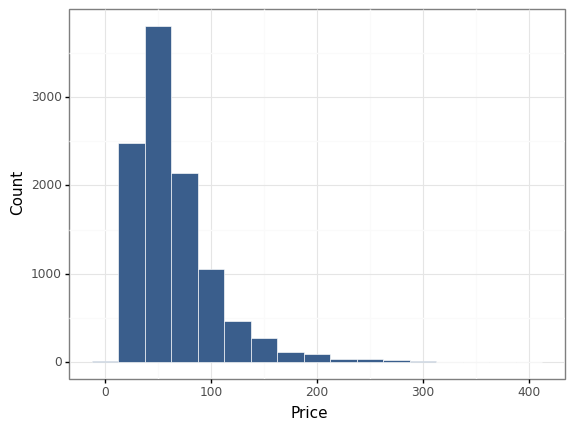

<ggplot: (8780114050809)>

In [31]:
# Histograms
(
    ggplot(data, aes('price'))
    + geom_histogram(
        binwidth=25, fill=color[0], color='white', alpha=0.8, size=0.25, closed='left'
    )
    + ylab('Count')
    + xlab('Price')
    + theme_bw()
)

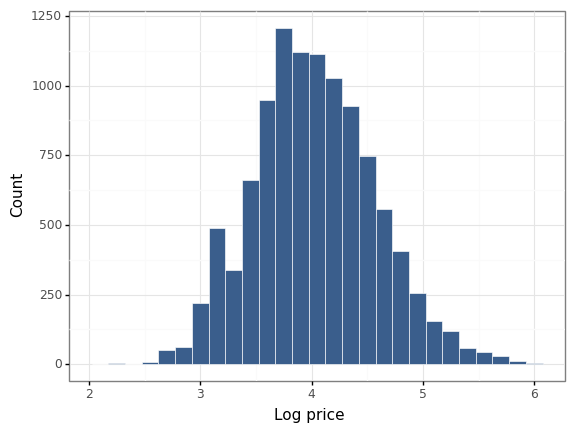

<ggplot: (8780101085993)>

In [32]:
(
    ggplot(data, aes('ln_price'))
    + geom_histogram(
        binwidth=0.15, fill=color[0], color='white', alpha=0.8, size=0.25, closed='left'
    )
    + ylab('Count')
    + xlab('Log price')
    + theme_bw()
)

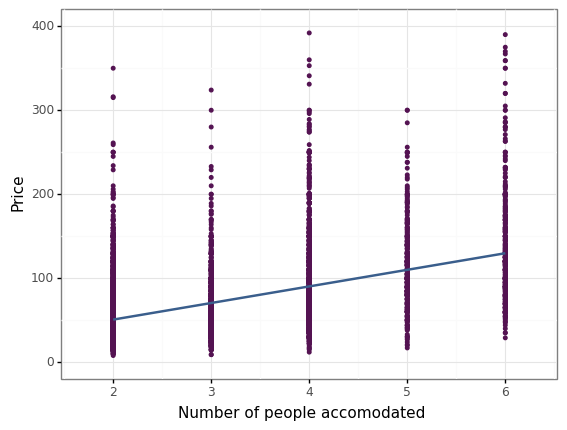

<ggplot: (8780080439557)>

In [33]:
(
    ggplot(data, aes(x='n_accommodates', y='price'))
    + geom_point(size=1, colour=color[2])
    + ylim(0, 400)
    + xlim(1.7, 6.3)
    + labs(x='Number of people accomodated', y='Price')
    + geom_smooth(method='lm', colour=color[0], se=False)
    + theme_bw()
)

In [34]:
data.groupby('n_accommodates').agg(mean_price=('price', np.mean))

,mean_price
n_accommodates,
2.0,51.712230
3.0,65.236636
4.0,89.119913
5.0,111.515075
6.0,135.908397


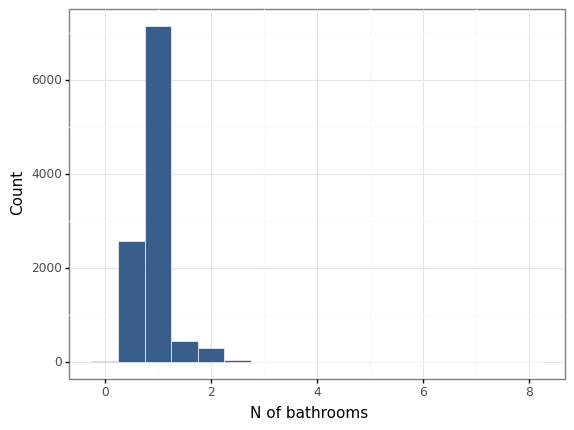

<ggplot: (8780081285693)>

In [35]:
## bathrooms
(
    ggplot(data, aes('n_bathrooms'))
    + geom_histogram(
        binwidth=0.5, closed='left', fill=color[0], color='white', alpha=0.8, size=0.25
    )
    + ylab('Count')
    + xlab('N of bathrooms')
    + theme_bw()
)

In [36]:
# Pool accomodations with 0,1,[2~10) bathrooms
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 10)], closed='left')
f_bath = pd.cut(data['n_bathrooms'].to_list(), bins, labels=['0', '1', '2'])
f_bath.categories = [0, 1, 2]
data['f_bathroom'] = f_bath

In [37]:
data.groupby('f_bathroom').agg(mean_price=('price', np.mean), n=('price', 'size'))

,mean_price,n
f_bathroom,,
0,39.615027,2795
1,71.936936,7421
2,132.310734,354


In [38]:
data.groupby('n_beds').agg(
    mean_price=('price', np.mean),
    min_price=('price', np.min),
    max_price=('price', np.max),
    n=('price', 'size'),
)

,mean_price,min_price,max_price,n
n_beds,,,,
0.0,64.596306,16.0,277.0,379
1.0,53.140251,10.0,350.0,6139
2.0,73.506385,8.0,360.0,2741
3.0,98.515228,16.0,359.0,788
4.0,115.537791,23.0,390.0,344
5.0,116.352381,21.0,305.0,105
6.0,127.984848,24.0,392.0,66
7.0,155.857143,69.0,266.0,7
8.0,85.000000,85.0,85.0,1


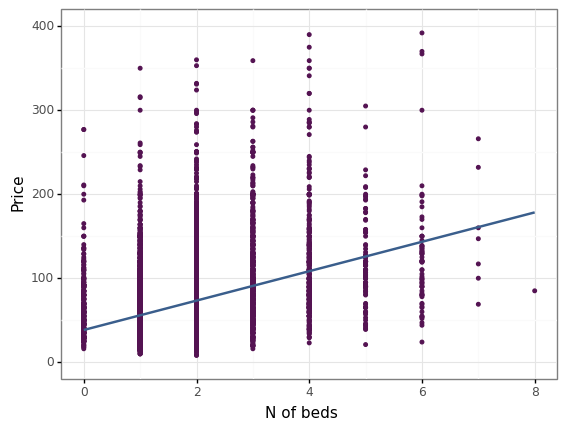

<ggplot: (8780063410125)>

In [39]:
(
    ggplot(data, aes(x='n_beds', y='price'))
    + geom_point(size=1, colour=color[2])
    + ylim(0, 400)
    + xlim(0, 8)
    + labs(x='N of beds', y='Price')
    + geom_smooth(method='lm', colour=color[0], se=False)
    + theme_bw()
)

In [40]:
## Number of reviews
nreview_plot = data.loc[data.n_number_of_reviews <200]

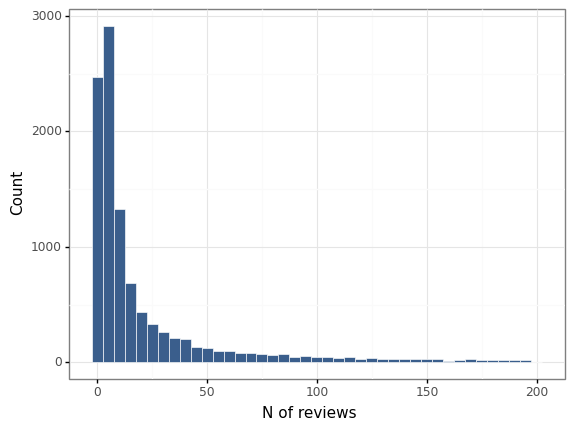

<ggplot: (8780101564245)>

In [41]:
(
    ggplot(nreview_plot, aes('n_number_of_reviews'))
    + geom_histogram(binwidth=5, fill=color[0], color='white', alpha=0.8, size=0.25)
    + ylab('Count')
    + xlab('N of reviews')
    + theme_bw()
)

In [42]:
bins = pd.IntervalIndex.from_tuples([(0, 2), (2, 51), (51, max(data.n_number_of_reviews))], closed='left')
f_number_of_reviews = pd.cut(data['n_number_of_reviews'].to_list(), bins, labels=['0', '1', '2'])
f_number_of_reviews.categories = [0, 1, 2]
data['f_number_of_reviews'] = f_number_of_reviews

In [43]:
data.groupby('f_number_of_reviews').agg(median_price=('price', np.median), mean_price=('price', np.mean), n=('price', 'size'))

,median_price,mean_price,n
f_number_of_reviews,,,
0,50.0,59.757487,1369
1,54.0,63.947526,7661
2,65.0,77.755036,1539


In [44]:
# number of reviews: use logs as well
data['ln_number_of_reviews']=np.log(data.n_number_of_reviews+1)

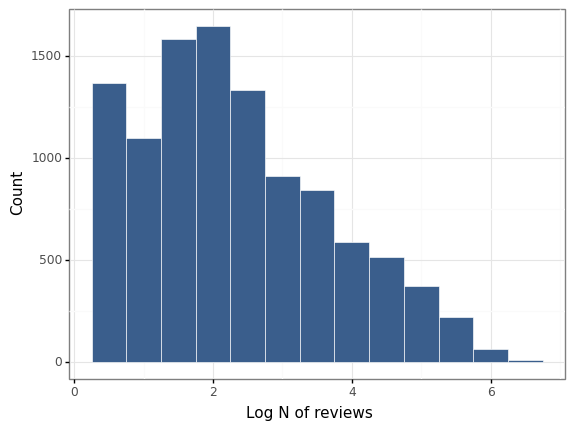

<ggplot: (8780063606269)>

In [45]:
(
    ggplot(data, aes('ln_number_of_reviews'))
    + geom_histogram(binwidth=0.5, fill=color[0], color="white", alpha=0.8, size=0.25)
    + ylab('Count')
    + xlab('Log N of reviews')
    + theme_bw()
)

In [46]:
data['ln_days_since'] = np.log(data['n_days_since'])

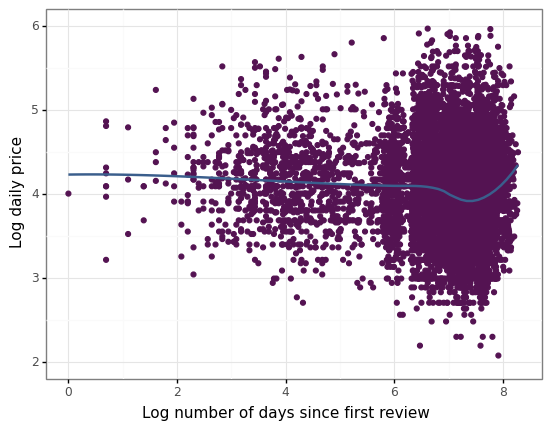

<ggplot: (8780064248841)>

In [47]:
(
    ggplot(data, aes(x='ln_days_since', y='ln_price'))
    + geom_point(size=1.5, colour=color[2])
    + ylim(2, 6)
    + xlim(0, 8.3)
    + geom_smooth(method='loess', colour=color[0], se=False)
    + labs(x='Log number of days since first review', y='Log daily price')
    + theme_bw()
)

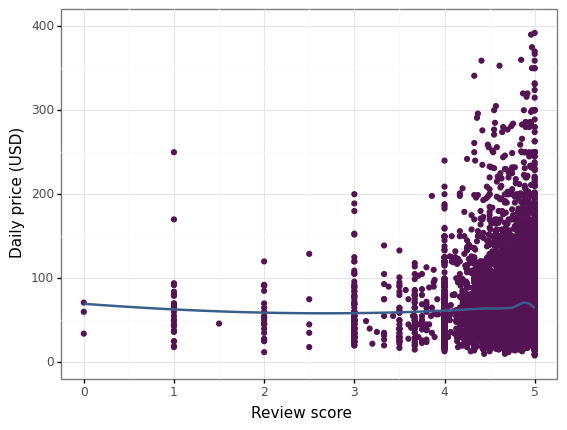

<ggplot: (8780101918693)>

In [48]:
## review score effect
(
    ggplot(data, aes(x='n_review_scores_rating', y='price'))
    + geom_point(size=1.5, colour=color[2])
    + ylim(0, 400)
    + xlim(0, 5)
    + geom_smooth(method="loess", colour=color[0], se=False)
    + labs(x='Review score', y='Daily price (USD)')
    + theme_bw()
)

## Data Prediction

In [49]:
# where do we have missing variables now?
na_filter=data.isna().sum()
na_filter[na_filter>0].index

Index(['f_number_of_reviews'], dtype='object')

In [50]:
data['f_number_of_reviews']=data['f_number_of_reviews'].fillna(1)

In [51]:
data.groupby('f_property_type').agg(mean_price=('price', np.mean))

,mean_price
f_property_type,
entire uint,80.656145
private room,40.812067


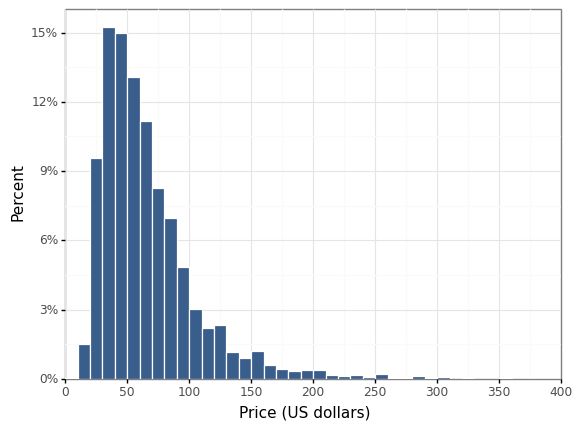

<ggplot: (8780063378921)>

In [52]:
# Distribution of price by type below 400# Histograms# price
(
    ggplot(data, aes(x='price'))
    + geom_histogram(
        aes(y='stat(count)/sum(stat(count))'),
        binwidth=10,
        fill=color[0],
        color='white',
        alpha=0.8,
        boundary=0,
        closed='left',
    )
    + labs(x='Price (US dollars)', y='Percent')
    + scale_y_continuous(
        expand=(0.00, 0.00),
        limits=(0, 0.16),
        breaks=seq(0, 0.16, by=0.03),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=(0.00, 0.00), limits=(0, 400), breaks=seq(0, 401, 50))
    + theme_bw()
)

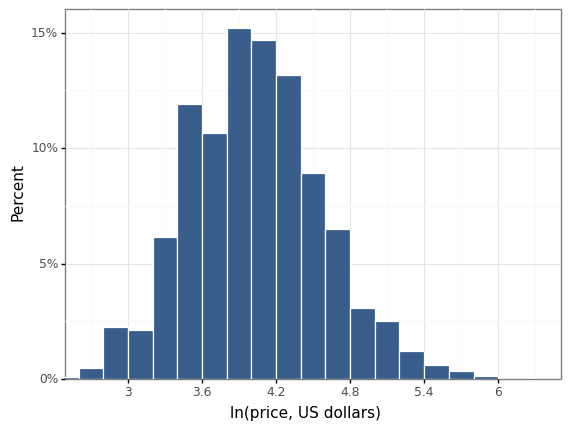

<ggplot: (8780102201793)>

In [53]:
(
    ggplot(data, aes(x='ln_price'))
    + geom_histogram(
        aes(y='stat(count)/sum(stat(count))'),
        binwidth=0.2,
        fill=color[0],
        color='white',
        alpha=0.8,
        boundary=0,
        closed='left',
    )
    + coord_cartesian(xlim=(2.5, 6.5))
    + scale_y_continuous(
        expand=(0.00, 0.00),
        limits=(0, 0.16),
        breaks=seq(0, 0.16, by=0.05),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=(0.00, 0.01), breaks=seq(2.4, 6.7, 0.6))
    + labs(x='ln(price, US dollars)', y='Percent')
    + theme_bw()
)

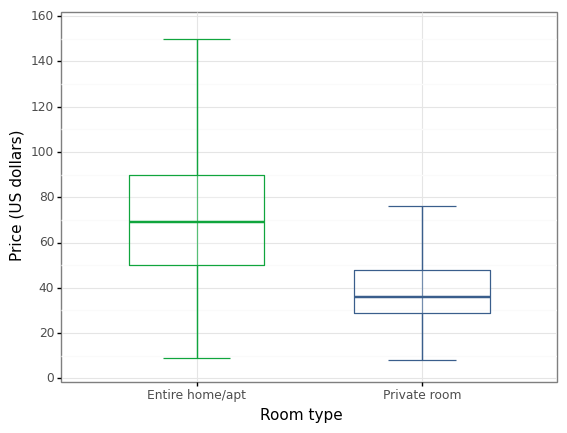

<ggplot: (8780113983697)>

In [54]:
## Boxplot of price by room type
(
    ggplot(data, aes(x='f_room_type', y='price'))
    + stat_boxplot(
        aes(group='f_room_type'),
        geom='errorbar',
        width=0.3,
        color=(color[1], color[0]),
        size=0.5,
        na_rm=True,
    )
    + geom_boxplot(
        aes(group='f_room_type'),
        color=(color[1], color[0]),
        size=0.5,
        width=0.6,
        alpha=0.3,
        na_rm=True,
        outlier_shape='',
    )
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 160), breaks=seq(0, 201, 20))
    + labs(x='Room type', y='Price (US dollars)')
    + theme_bw()
)

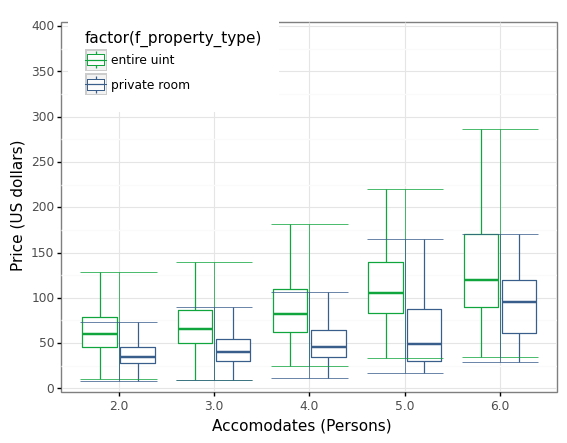

<ggplot: (8780101087057)>

In [55]:
(
    ggplot(
        data,
        aes(
            x='factor(n_accommodates)',
            y='price',
            color='factor(f_property_type)',
        ),
    )
    + geom_boxplot(alpha=0.8, na_rm=True, outlier_shape='', width=0.8, stat='boxplot')
    + stat_boxplot(geom='errorbar', width=0.8, size=0.3, na_rm=True)
    + scale_color_manual(name='', values=(color[1], color[0]))
    + scale_fill_manual(name='', values=(color[1], color[0]))
    + labs(x='Accomodates (Persons)', y='Price (US dollars)')
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 400), breaks=seq(0, 401, 50))
    + theme_bw()
    + theme(legend_position=(0.3, 0.8))
)

In [56]:
## Helper functions
def price_diff_by_variables2(df, factor_var, dummy_var, factor_lab, dummy_lab):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=('price', np.mean), sd=('price', np.std), size=('price', 'size')
    )
    stats['se'] = stats['sd'] / stats['size'] ** (1 / 2)
    stats['Mean_l'] = stats['Mean'] - (1.96 * stats['se'])
    stats['Mean_u'] = stats['Mean'] + (1.96 * stats['se'])
    stats = stats.drop(['sd', 'size'], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill='factor(' + stats.columns[1] + ')',
            ),
        )
        + geom_bar(stat='identity', position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin='Mean_l', ymax='Mean_u'),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=(color[1], color[0]))
        + scale_fill_manual(name=dummy_lab, values=(color[1], color[0]))
        + ylab('Mean Price')
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position='top',
            legend_box='vertical',
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face='bold'),
        )
    )

    return plot

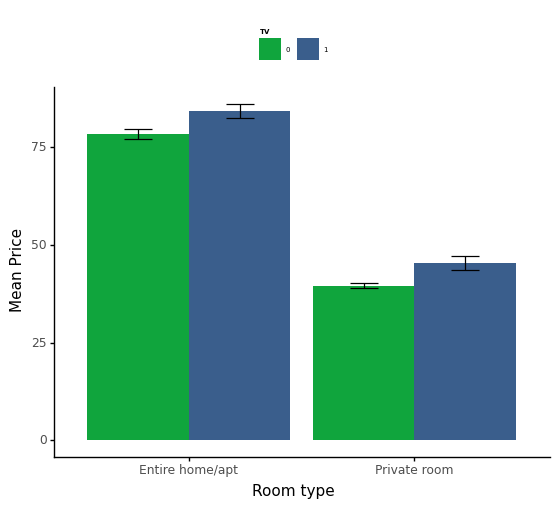

<ggplot: (8780097521333)>

In [57]:
price_diff_by_variables2(data,'f_room_type','d_TV','Room type', 'TV')

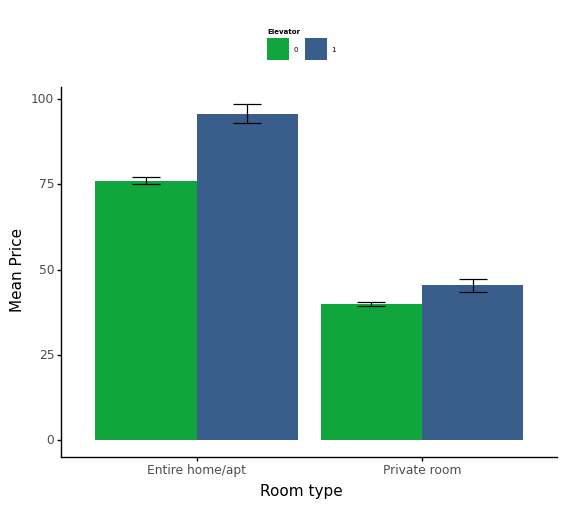

<ggplot: (8780064845565)>

In [58]:
price_diff_by_variables2(data,'f_room_type','d_Elevator','Room type', 'Elevator')

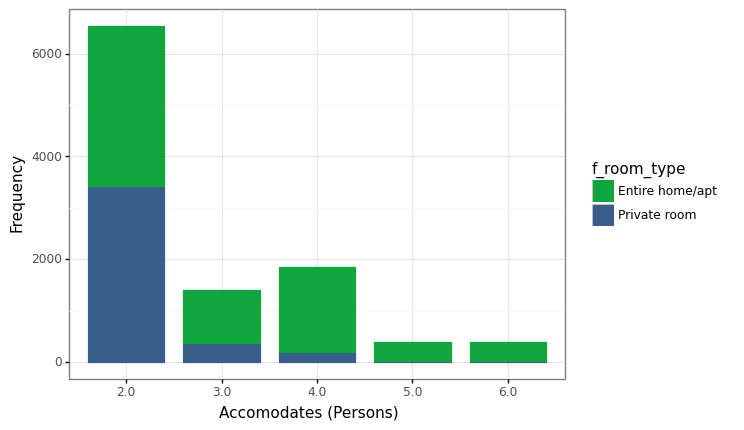

<ggplot: (8780102166945)>

In [59]:
# Barchart
(
    ggplot(
        data, aes(x='factor(n_accommodates)', color='f_room_type', fill='f_room_type')
    )
    + geom_bar(alpha=0.8, na_rm=True, width=0.8)
    + scale_color_manual(name='', values=(color[1], color[0], color[2]))
    + scale_fill_manual(name='', values=(color[1], color[0], color[2]))
    + labs(x='Accomodates (Persons)', y='Frequency')
    + theme_bw()
    + theme(legend_position='right')
)

## Model Selection

In [60]:
data.drop(columns=['neighbourhood_cleansed', 'room_type', 'property_type', 'f_property_type',
                  'f_room_type2', 'f_neighbourhood_cleansed', 'f_neighbourhood_group_cleansed',
                  'ln_price', 'id'], axis=1, inplace=True)

In [61]:
data['f_room_type'] = (data['f_room_type'] == 'Entire home/apt').astype(int)

In [62]:
X = data.drop(['price'], axis=1)  # X
y = data['price']  # target
# data standard
ss = StandardScaler()
X_std = ss.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

### ols model

In [63]:
ols_model = LinearRegression().fit(X_train, y_train)
y_hat = ols_model.predict(X_test)
ols_rmse = mean_squared_error(y_test, y_hat, squared=False)

In [64]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist(),
    index=X.columns,
    columns=['ols_coefficient'],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))
ols_model_coeffs_df.sort_values('ols_coefficient', inplace=True, ascending=False)

<AxesSubplot:title={'center':'OLS Model Coeffs'}>

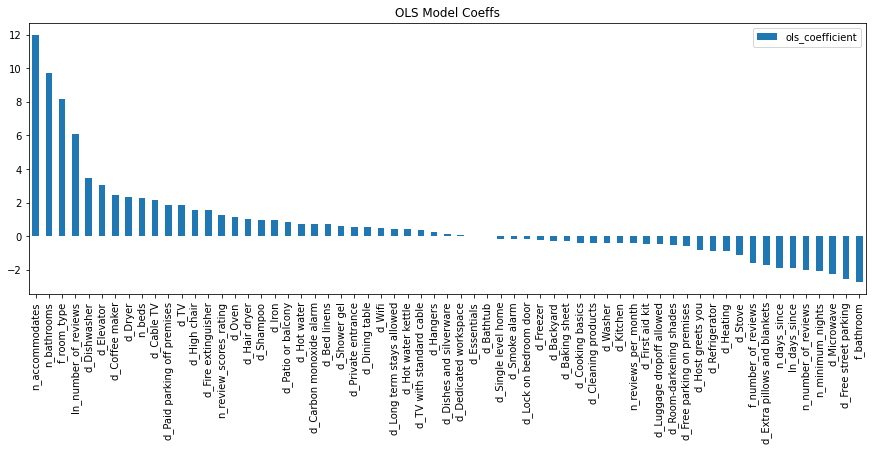

In [65]:
ols_model_coeffs_df.plot.bar(y='ols_coefficient', rot=90, figsize=(15, 5), title='OLS Model Coeffs')

In [66]:
ols_model_coeffs_var_imp_df = (
    pd.DataFrame(
        abs(ols_model.coef_), X.columns
    )
    .reset_index()
    .rename({'index': 'varname',0: 'imp'}, axis=1)
    .assign(imp_percentage=lambda x: x['imp'] / x['imp'].sum())
    .sort_values(by=['imp'], ascending=False)
)

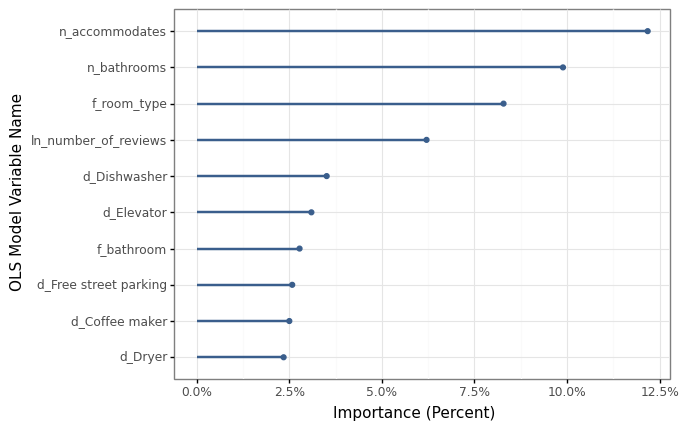

<ggplot: (8780102928985)>

In [67]:
ggplot(
    ols_model_coeffs_var_imp_df.iloc[:10, :],
    aes(x='reorder(varname, imp)', y='imp_percentage'),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x='varname', xend='varname', y=0, yend='imp_percentage'), color=color[0], size=1
) + ylab(
    'Importance (Percent)'
) + xlab(
    'OLS Model Variable Name'
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

In [68]:
# cross validation
ols_model = LinearRegression()
ols_cv_mse = cross_val_score(ols_model, X_std, y, cv=5, scoring='neg_mean_squared_error')
ols_cv_rmse = [np.sqrt(-x) for x in ols_cv_mse]

In [69]:
ols_cv_rmse

[29.284120788934754,
 32.53828249431209,
 29.392151995967886,
 31.24123665815015,
 31.15720610133196]

### lasso model

In [70]:
lasso_model = Lasso(alpha=0.5).fit(X_train, y_train)
y_hat = lasso_model.predict(X_test)
lasso_rmse = mean_squared_error(y_test, y_hat, squared=False)

In [71]:
lasso_model_coeffs_df = pd.DataFrame(
    lasso_model.coef_.tolist(),
    index=X.columns,
    columns=['lasso_coefficient'],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3))
lasso_model_coeffs_df.sort_values('lasso_coefficient', inplace=True, ascending=False)

<AxesSubplot:title={'center':'lasso Model Coeffs'}>

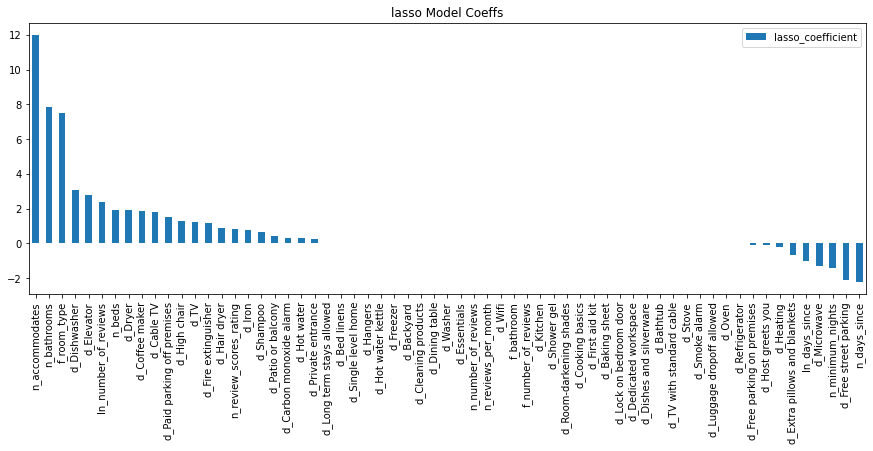

In [72]:
lasso_model_coeffs_df.plot.bar(y='lasso_coefficient', rot=90, figsize=(15, 5), title='lasso Model Coeffs')

In [73]:
lasso_model_coeffs_var_imp_df = (
    pd.DataFrame(
        abs(lasso_model.coef_), X.columns
    )
    .reset_index()
    .rename({'index': 'varname',0: 'imp'}, axis=1)
    .assign(imp_percentage=lambda x: x['imp'] / x['imp'].sum())
    .sort_values(by=['imp'], ascending=False)
)

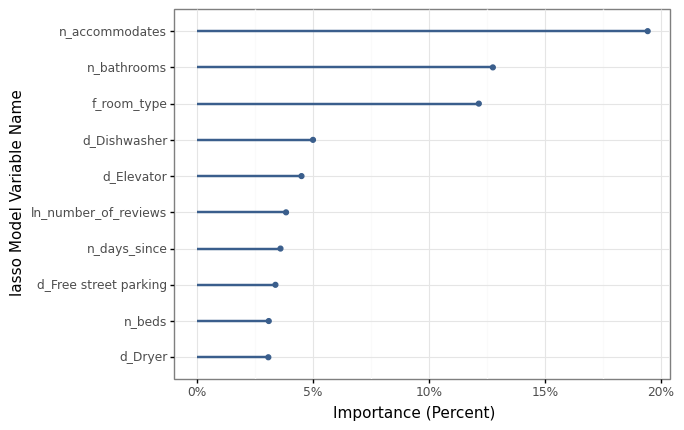

<ggplot: (8780063600621)>

In [74]:
ggplot(
    lasso_model_coeffs_var_imp_df.iloc[:10, :],
    aes(x='reorder(varname, imp)', y='imp_percentage'),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x='varname', xend='varname', y=0, yend='imp_percentage'), color=color[0], size=1
) + ylab(
    'Importance (Percent)'
) + xlab(
    'lasso Model Variable Name'
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

In [75]:
# cross validation
lasso_model = Lasso(alpha=0.5)
lasso_cv_mse = cross_val_score(lasso_model, X_std, y, cv=5, scoring='neg_mean_squared_error')
lasso_cv_rmse = [np.sqrt(-x) for x in lasso_cv_mse]

In [76]:
lasso_cv_rmse

[29.038324229640647,
 32.84099823915201,
 29.473791861809993,
 31.274808005783054,
 30.921404013044633]

### CART Model

In [77]:
cart_model = DecisionTreeRegressor().fit(X_train, y_train)
y_hat = cart_model.predict(X_test)
cart_rmse = mean_squared_error(y_test, y_hat, squared=False)

In [78]:
cart_model_coeffs_df = pd.DataFrame(
    cart_model.feature_importances_.tolist(),
    index=X.columns,
    columns=['cart_coefficient'],
).assign(cart_coefficient=lambda x: x.cart_coefficient.round(3))
cart_model_coeffs_df.sort_values('cart_coefficient', inplace=True, ascending=False)

<AxesSubplot:title={'center':'cart Model Coeffs'}>

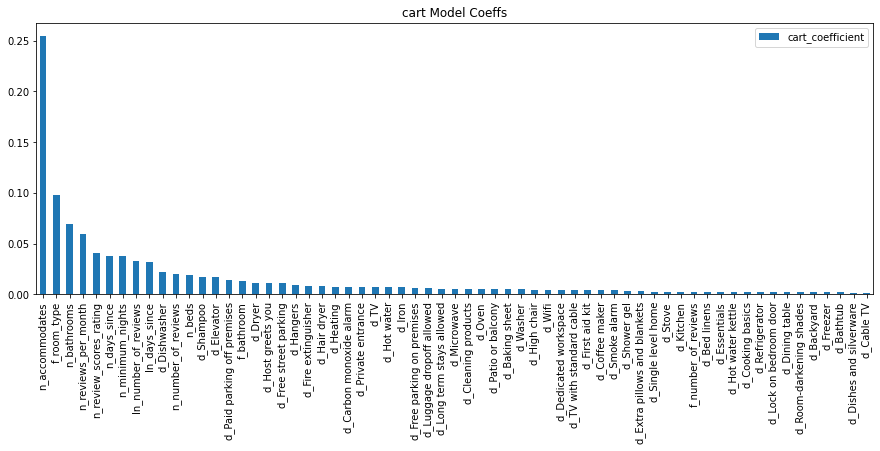

In [79]:
cart_model_coeffs_df.plot.bar(y='cart_coefficient', rot=90, figsize=(15, 5), title='cart Model Coeffs')

In [80]:
cart_model_coeffs_var_imp_df = (
    pd.DataFrame(
        abs(cart_model.feature_importances_), X.columns
    )
    .reset_index()
    .rename({'index': 'varname',0: 'imp'}, axis=1)
    .assign(imp_percentage=lambda x: x['imp'] / x['imp'].sum())
    .sort_values(by=['imp'], ascending=False)
)

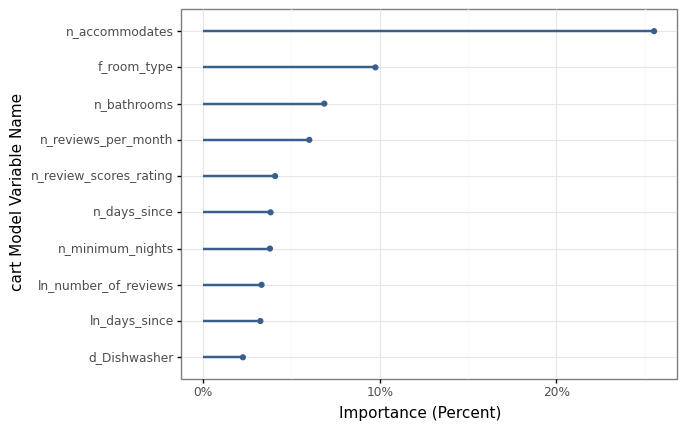

<ggplot: (8780101066989)>

In [81]:
ggplot(
    cart_model_coeffs_var_imp_df.iloc[:10, :],
    aes(x='reorder(varname, imp)', y='imp_percentage'),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x='varname', xend='varname', y=0, yend='imp_percentage'), color=color[0], size=1
) + ylab(
    'Importance (Percent)'
) + xlab(
    'cart Model Variable Name'
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

In [82]:
# cross validation
cart_model = DecisionTreeRegressor()
cart_cv_mse = cross_val_score(cart_model, X_std, y, cv=5, scoring='neg_mean_squared_error')
cart_cv_rmse = [np.sqrt(-x) for x in cart_cv_mse]

In [83]:
cart_cv_rmse

[53.453739537820034,
 42.54787497736964,
 41.18469716999163,
 43.47195944834033,
 44.67841573450136]

### GBM Model

In [84]:
gbm_model = GradientBoostingRegressor().fit(X_train, y_train)
y_hat = gbm_model.predict(X_test)
gbm_rmse = mean_squared_error(y_test, y_hat, squared=False)

In [85]:
gbm_model_coeffs_df = pd.DataFrame(
    gbm_model.feature_importances_.tolist(),
    index=X.columns,
    columns=['gbm_coefficient'],
).assign(gbm_coefficient=lambda x: x.gbm_coefficient.round(3))
gbm_model_coeffs_df.sort_values('gbm_coefficient', inplace=True, ascending=False)

<AxesSubplot:title={'center':'gbm Model Coeffs'}>

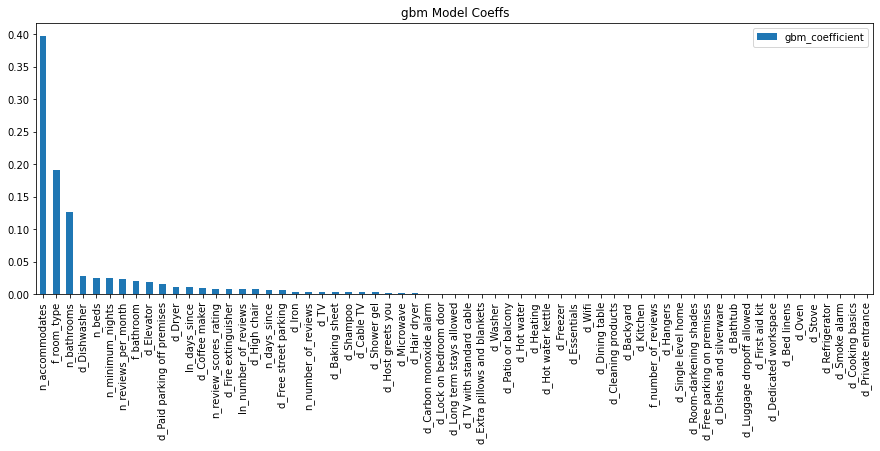

In [86]:
gbm_model_coeffs_df.plot.bar(y='gbm_coefficient', rot=90, figsize=(15, 5), title='gbm Model Coeffs')

In [87]:
gbm_model_coeffs_var_imp_df = (
    pd.DataFrame(
        abs(gbm_model.feature_importances_), X.columns
    )
    .reset_index()
    .rename({'index': 'varname',0: 'imp'}, axis=1)
    .assign(imp_percentage=lambda x: x['imp'] / x['imp'].sum())
    .sort_values(by=['imp'], ascending=False)
)

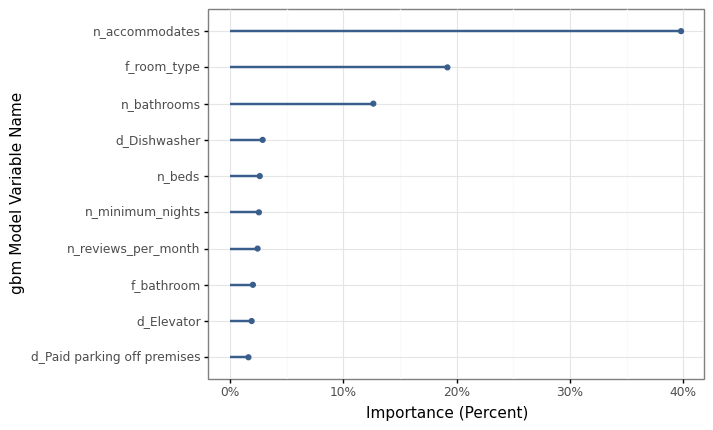

<ggplot: (8780064302901)>

In [88]:
ggplot(
    gbm_model_coeffs_var_imp_df.iloc[:10, :],
    aes(x='reorder(varname, imp)', y='imp_percentage'),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x='varname', xend='varname', y=0, yend='imp_percentage'), color=color[0], size=1
) + ylab(
    'Importance (Percent)'
) + xlab(
    'gbm Model Variable Name'
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

In [89]:
# cross validation
gbm_model = GradientBoostingRegressor()
gbm_cv_mse = cross_val_score(gbm_model, X_std, y, cv=5, scoring='neg_mean_squared_error')
gbm_cv_rmse = [np.sqrt(-x) for x in gbm_cv_mse]

In [90]:
gbm_cv_rmse

[28.504728412790122,
 31.12546589850167,
 28.587381251253383,
 30.24569382069324,
 30.283697989586024]

In [91]:
def combine(type_, rmse):
    res = []
    index = 1
    for r in rmse:
        res.append([index, type_, r])
        index += 1
    return res

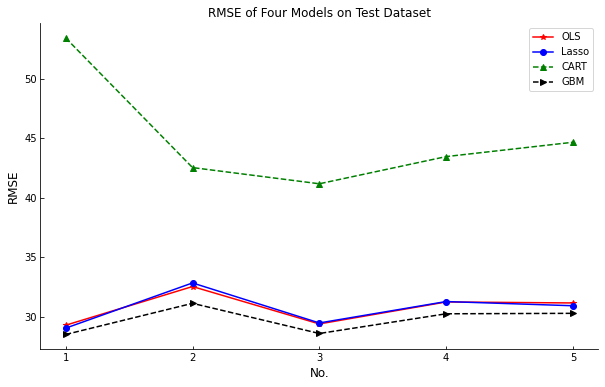

In [92]:
# cv RMSE compare
plt.figure(figsize=(10, 6))
plt.xlabel('No.', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
serial = [1, 2, 3, 4, 5]
plt.plot(serial, ols_cv_rmse, 'r-*', label='OLS')
plt.plot(serial, lasso_cv_rmse, 'b-o', label='Lasso')
plt.plot(serial, cart_cv_rmse, 'g--^', label='CART')
plt.plot(serial, gbm_cv_rmse, 'k-->', label='GBM')
plt.title('RMSE of Four Models on Test Dataset')
plt.xticks(serial)
plt.legend()
plt.show()

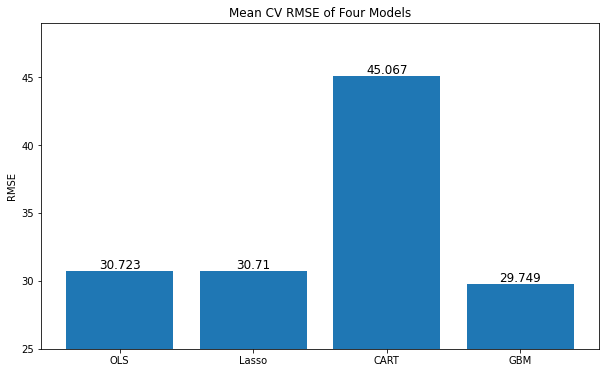

In [96]:
plt.figure(figsize=(10, 6))
x_list = ['OLS', 'Lasso', 'CART', 'GBM']
y_list = [round(np.mean(ols_cv_rmse), 3), 
          round(np.mean(lasso_cv_rmse), 3), 
          round(np.mean(cart_cv_rmse), 3), 
          round(np.mean(gbm_cv_rmse), 3)]
plt.bar(x_list, y_list)
plt.title('Mean CV RMSE of Four Models')
plt.ylabel('RMSE')
plt.ylim([25, 49])
for a, b in zip(x_list, y_list):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=12)
plt.show()

## GBM is the best